In [1]:
import pandas as pd
import geopandas as gpd
from meteostat import Stations, Hourly,Daily
from datetime import datetime
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import h3
import folium
import osmnx as ox
from shapely.ops import unary_union
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt
from holidays import country_holidays

In [2]:
df = pd.read_csv('data/Taxi_Trips_-_2023.csv') #this file can download from our google drive

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495570 entries, 0 to 6495569
Data columns (total 24 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         float64
 7   Dropoff Census Tract        float64
 8   Pickup Community Area       float64
 9   Dropoff Community Area      float64
 10  Fare                        float64
 11  Tips                        float64
 12  Tolls                       float64
 13  Extras                      float64
 14  Trip Total                  float64
 15  Payment Type                object 
 16  Company                     object 
 17  Pickup Centroid Latitude    float64
 18  Pickup Centroid Longitude   float64
 19  Pickup Centroid Locat

In [4]:
#Convert columns to string
df[['Pickup Census Tract','Dropoff Census Tract', 
    'Pickup Community Area','Dropoff Community Area']] = df[['Pickup Census Tract','Dropoff Census Tract', 
                                                             'Pickup Community Area','Dropoff Community Area']].fillna(0).astype(int).astype(str).replace('0', None)

df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])
df['Trip End Timestamp'] = pd.to_datetime(df['Trip End Timestamp'])

df.drop(['Pickup Community Area','Dropoff Community Area'], axis=1, inplace=True)

In [5]:
df.isnull().mean() * 100

Trip ID                        0.000000
Taxi ID                        0.002386
Trip Start Timestamp           0.000000
Trip End Timestamp             0.001278
Trip Seconds                   0.019783
Trip Miles                     0.000308
Pickup Census Tract           55.679271
Dropoff Census Tract          56.811211
Fare                           0.186943
Tips                           0.186943
Tolls                          0.186943
Extras                         0.186943
Trip Total                     0.186943
Payment Type                   0.000000
Company                        0.000000
Pickup Centroid Latitude       3.689407
Pickup Centroid Longitude      3.689407
Pickup Centroid Location       3.689407
Dropoff Centroid Latitude      8.928300
Dropoff Centroid Longitude     8.928300
Dropoff Centroid  Location     8.928300
Community Areas                3.689699
dtype: float64

Problem:

Definition: The longitude (latitude) of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.

--> Two issues:
- 1. Null values for locations outside Chicago
  2. Mix longitude (latitude) of census tract and community area

--> If "Pickup Census Tract" is null, the longitude (latitude) is from "Community Area". Otherwise, the longitude (latitude) is from "Census Tract"

# 1. Filling missing values

In [6]:
# Load the shapefiles or GeoJSON files
census_tracts = gpd.read_file('Boundaries - Census Tracts - 2010/geo_export_43205675-be18-433e-beb4-7eb585400a4e.shp')
#community_areas = gpd.read_file('community_area/geo_export_0ec1e45e-aa60-4dc6-a5c8-cb395ee19c94.shp')

census_tracts['count_areas'] = census_tracts.groupby('geoid10')['commarea'].transform('nunique')

census_tracts['count_areas'].unique()
census_tracts['centroid'] = census_tracts.geometry.centroid
census_tracts['latitude'] = census_tracts['centroid'].y
census_tracts['longitude'] = census_tracts['centroid'].x

In [7]:
# Create GeoDataFrames for pickup and dropoff coordinates
pickup_geometry = [Point(xy) for xy in zip(df['Pickup Centroid Longitude'], df['Pickup Centroid Latitude'])]
dropoff_geometry = [Point(xy) for xy in zip(df['Dropoff Centroid Longitude'], df['Dropoff Centroid Latitude'])]

pickup_gdf = gpd.GeoDataFrame(df, geometry=pickup_geometry, crs=census_tracts.crs)
dropoff_gdf = gpd.GeoDataFrame(df, geometry=dropoff_geometry, crs=census_tracts.crs)

# Perform spatial joins to find the census tract for each pickup and dropoff coordinate
pickup_matched = gpd.sjoin(pickup_gdf, census_tracts, how="left", predicate='intersects')
dropoff_matched = gpd.sjoin(dropoff_gdf, census_tracts, how="left", predicate='intersects')

# Add the census tract information to the original DataFrame
df['Pickup Census Tract'] = pickup_matched['geoid10']
df['Dropoff Census Tract'] = dropoff_matched['geoid10']

In [8]:
df.isnull().mean() * 100

Trip ID                       0.000000
Taxi ID                       0.002386
Trip Start Timestamp          0.000000
Trip End Timestamp            0.001278
Trip Seconds                  0.019783
Trip Miles                    0.000308
Pickup Census Tract           3.726186
Dropoff Census Tract          9.538316
Fare                          0.186943
Tips                          0.186943
Tolls                         0.186943
Extras                        0.186943
Trip Total                    0.186943
Payment Type                  0.000000
Company                       0.000000
Pickup Centroid Latitude      3.689407
Pickup Centroid Longitude     3.689407
Pickup Centroid Location      3.689407
Dropoff Centroid Latitude     8.928300
Dropoff Centroid Longitude    8.928300
Dropoff Centroid  Location    8.928300
Community Areas               3.689699
dtype: float64

In [9]:
df = df.dropna()

# 2. Create hexagons 

In [10]:
resolution = 7# <--- Add or remove resolution here 
hex_geo = f'hex_geometry_{resolution}'
hex_id = f'hex_id_{resolution}'

In [11]:
def create_hexagons(gdf, resolution):

    def get_hexagons_from_polygon(polygon, resolution):
        hexagons = set()
        if polygon.geom_type == 'MultiPolygon':
            for part in polygon.geoms:
                hexagons.update(h3.polyfill(part.__geo_interface__, resolution,True))
        else:
            hexagons.update(h3.polyfill(polygon.__geo_interface__, resolution,True))
        return list(hexagons)

    union_polygon = gdf['geometry'].unary_union

    hexagon_ids = get_hexagons_from_polygon(union_polygon, resolution)

    def hexagon_to_polygon(hex_id):
        boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
        return Polygon(boundary)

    hexagon_geometries = [hexagon_to_polygon(hex_id) for hex_id in hexagon_ids]

    centroids = [geom.centroid for geom in hexagon_geometries]

    latitude = [centroid.y for centroid in centroids]
    longitude = [centroid.x for centroid in centroids]

    hexagon_gdf = gpd.GeoDataFrame({
        f'hex_id_{resolution}': hexagon_ids,
        'geometry': hexagon_geometries,
        f'centroid_{resolution}': centroids,
        f'lat_{resolution}': latitude,
        f'lon_{resolution}': longitude
    }, crs=gdf.set_geometry("geometry").crs)
    
    hexagon_gdf.rename(columns={'geometry': f'hex_geometry_{resolution}'}, inplace=True)
    return hexagon_gdf

hexagon = create_hexagons(census_tracts, resolution)

See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


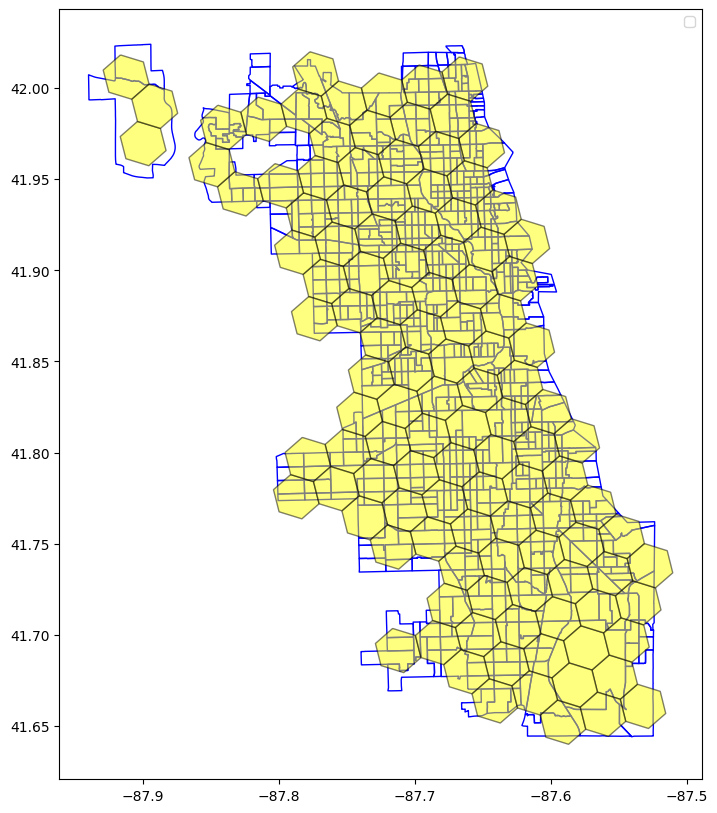

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
census_tracts['geometry'].plot(ax=ax, color='None', edgecolor='blue', label='Census Tracts')
hexagon[hex_geo].plot(ax=ax, color='yellow', alpha=0.5, edgecolor='black', label='Hexagons')
plt.legend()
plt.show()

# 3. Aggregation 

## a. Census tracts

In [13]:
df['Date'] = df['Trip Start Timestamp'].dt.date
df['Hour'] = df['Trip Start Timestamp'].dt.strftime('%Y-%m-%d %H:00:00') 

aggregation_functions = {
     'Trip ID': 'count',
    'Trip Seconds': 'sum',
    'Trip Miles': 'sum',
    'Fare': 'sum',
    'Tips': 'sum',
    'Tolls': 'sum',
    'Extras': 'sum',
    'Trip Total': 'sum'
}

# Daily aggregation
daily_tract_agg = df.groupby(['Date', 'Pickup Census Tract']).agg(aggregation_functions)
daily_tract_agg = daily_tract_agg.rename(columns={'Trip ID': 'Number of Trips'}).reset_index()
daily_tract_agg = daily_tract_agg.merge(census_tracts[['geoid10','geometry']], left_on='Pickup Census Tract',right_on='geoid10', how='left')
daily_tract_agg.drop('geoid10',axis=1,inplace=True)

# Hourly aggregation
hourly_tract_agg = df.groupby(['Hour', 'Pickup Census Tract']).agg(aggregation_functions)
hourly_tract_agg = hourly_tract_agg.rename(columns={'Trip ID': 'Number of Trips'}).reset_index()
hourly_tract_agg = hourly_tract_agg.merge(census_tracts[['geoid10','geometry']], left_on='Pickup Census Tract',right_on='geoid10', how='left')
hourly_tract_agg.drop('geoid10',axis=1,inplace=True)

## b. Hexagons

In [14]:
#Daily

census_tracts_trips = census_tracts[['geoid10','geometry']].merge(daily_tract_agg.drop('geometry',axis=1), left_on='geoid10',right_on='Pickup Census Tract',how='left')
census_tracts_trips = census_tracts_trips.to_crs(epsg=26916) #measure in meters
census_tracts_trips['original_area'] = census_tracts_trips.geometry.area

hexagon = hexagon.set_geometry(hex_geo)
hexagon_m = hexagon.to_crs(epsg=26916)
intersections = gpd.overlay(census_tracts_trips, hexagon_m, how='intersection')

intersections['intersection_area'] = intersections.geometry.area
intersections['area_proportion'] = intersections['intersection_area'] / intersections['original_area']

for metric in list(aggregation_functions.keys())[1:]+ ['Number of Trips']:
    intersections[f'{metric}'] = intersections[metric] * intersections['area_proportion']
aggregated_columns = {f'{metric}': 'sum' for metric in list(aggregation_functions.keys())[1:] + ['Number of Trips']}

daily_hex_agg = intersections.groupby(['Date', hex_id]).agg(aggregated_columns).reset_index()
daily_hex_agg['Number of Trips'] = round(daily_hex_agg['Number of Trips'])
daily_hex_agg = daily_hex_agg.merge(hexagon[[hex_id,hex_geo]], on=hex_id, how='left')

In [15]:
#Hourly

census_tracts_trips = census_tracts[['geoid10','geometry']].merge(hourly_tract_agg.drop('geometry',axis=1), left_on='geoid10',right_on='Pickup Census Tract',how='left')
census_tracts_trips = census_tracts_trips.to_crs(epsg=26916) #measure in meters
census_tracts_trips['original_area'] = census_tracts_trips.geometry.area

hexagon_m = hexagon.to_crs(epsg=26916)
intersections = gpd.overlay(census_tracts_trips, hexagon_m, how='intersection')

intersections['intersection_area'] = intersections.geometry.area
intersections['area_proportion'] = intersections['intersection_area'] / intersections['original_area']

for metric in list(aggregation_functions.keys())[1:]+ ['Number of Trips']:
    intersections[f'{metric}'] = intersections[metric] * intersections['area_proportion']

hourly_hex_agg = intersections.groupby(['Hour', hex_id]).agg(aggregated_columns).reset_index()
hourly_hex_agg['Number of Trips'] = round(hourly_hex_agg['Number of Trips'])
hourly_hex_agg = hourly_hex_agg.merge(hexagon[[hex_id,hex_geo]], on=hex_id, how='left')

# 4. POI data

In [16]:
def hexagon_to_polygon(hex_id):
    boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    polygon = Polygon([(coord[0], coord[1]) for coord in boundary])  
    return gpd.GeoDataFrame({'geometry': [polygon]}, index=[0])


In [17]:
places = ['restaurant','bar', 'biergarten', 'fast_food', 'ice_cream', 'pub', 'cafe',
      'university','college', 'kindergarten', 'library', 'school', 
      'taxi', 'bank', 'hospital','casino','cinema','nightclub'] ##<-- Add or remove POI data here

## a. Census tracts

In [18]:
bbox = census_tracts.unary_union.bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

pois = ox.features_from_bbox(north, south, east, west, tags={'amenity': True})
relevant_pois = pois[pois['amenity'].isin(places)]

census_tracts.crs = "EPSG:4326" # used in census_tracts
relevant_pois = relevant_pois.to_crs(census_tracts.crs) #ensure CRS match

pois_with_tracts = gpd.sjoin(relevant_pois, census_tracts, how='left', predicate='within')
poi_counts = pois_with_tracts.groupby(['geoid10', 'amenity']).size().unstack(fill_value=0).reset_index()

daily_tract_agg = pd.merge(daily_tract_agg, poi_counts, left_on='Pickup Census Tract', right_on='geoid10', how='left')
daily_tract_agg[places] = daily_tract_agg[places].fillna(0)
daily_tract_agg.drop('geoid10',axis=1,inplace=True)

hourly_tract_agg = pd.merge(hourly_tract_agg, poi_counts, left_on='Pickup Census Tract', right_on='geoid10', how='left')
hourly_tract_agg[places] = hourly_tract_agg[places].fillna(0)
hourly_tract_agg.drop('geoid10',axis=1,inplace=True)

In [19]:
#Data for clustering

df = pd.merge(df, poi_counts, left_on='Pickup Census Tract', right_on='geoid10', how='left')
df[places] = df[places].fillna(0)
df.drop('geoid10',axis=1,inplace=True)

## b. Hexagons

In [20]:
bbox = hexagon.unary_union.bounds
north, south, east, west = bbox[3], bbox[1], bbox[2], bbox[0]

pois = ox.features_from_bbox(north, south, east, west, tags={'amenity': True})
relevant_pois = pois[pois['amenity'].isin(places)]

hexagon.crs = "EPSG:4326"
relevant_pois = relevant_pois.to_crs(hexagon.crs) #ensure CRS match

pois_with_tracts = gpd.sjoin(relevant_pois, hexagon, how='left', predicate='within')
poi_counts = pois_with_tracts.groupby([hex_id, 'amenity']).size().unstack(fill_value=0).reset_index()

daily_hex_agg = pd.merge(daily_hex_agg, poi_counts, on=hex_id, how='left')
daily_hex_agg[places] = daily_hex_agg[places].fillna(0)
#daily_hex_agg.drop(hex_id,axis=1,inplace=True)

hourly_hex_agg = pd.merge(hourly_hex_agg, poi_counts, on=hex_id, how='left')
hourly_hex_agg[places] = hourly_hex_agg[places].fillna(0)
#hourly_hex_agg.drop(hex_id,axis=1,inplace=True)

# 5. Weather data

Find the closest station from the location --> Retrieve the weather data from that station

In [21]:
start = datetime(2023, 1, 1)
end = datetime(2024, 1, 1)

# Get weather stations in Chicago
stations = Stations()
center_lat = census_tracts.geometry.centroid.y.mean()
center_lon = census_tracts.geometry.centroid.x.mean()
chicago_stations = stations.nearby(center_lat, center_lon)  
station_list = chicago_stations.fetch(6) #6 closest stations in Chicago
station_list = station_list.drop('KCGX0', axis=0) #Remove one unavailable station

hourly_weather_data = Hourly(list(station_list.index), start, end) 
hourly_weather_data = hourly_weather_data.fetch()
hourly_weather_data.reset_index(inplace =True)
hourly_weather_data['time'] = pd.to_datetime(hourly_weather_data['time'])
hourly_weather_data.drop(['snow','wpgt','tsun'],axis=1,inplace=True) #weather stations do not track this info

daily_weather_data = Daily(list(station_list.index), start, end) 
daily_weather_data = daily_weather_data.fetch()
daily_weather_data.reset_index(inplace =True)
daily_weather_data['time'] = pd.to_datetime(daily_weather_data['time'])
daily_weather_data.drop(['snow','wpgt','tsun'],axis=1,inplace=True) #weather stations do not track this info

## a. Census tracts

In [22]:
# Idea from ChatGPT to shorten the time
gdf_stations = gpd.GeoDataFrame(station_list, geometry=gpd.points_from_xy(station_list.longitude, station_list.latitude))
gdf_stations.crs = "EPSG:4326"  

gdf_census = gpd.GeoDataFrame(census_tracts, geometry=gpd.points_from_xy(census_tracts['longitude'], census_tracts['latitude']))
gdf_census.crs = "EPSG:4326"  

tree = cKDTree(np.array(list(zip(gdf_stations.geometry.x, gdf_stations.geometry.y))))

closest_stations = []
for point in gdf_census.geometry:
    dist, idx = tree.query(np.array([point.x, point.y]), k=1)
    closest_stations.append(gdf_stations.iloc[idx].name)

census_tracts['closest_station_census'] = closest_stations

In [23]:
daily_tract_agg = pd.merge(daily_tract_agg, census_tracts[['geoid10','closest_station_census']], left_on='Pickup Census Tract', right_on='geoid10', how='left')
daily_tract_agg['Date'] = pd.to_datetime(daily_tract_agg['Date'])
# Merge based on time and closest station
daily_tract_agg = pd.merge_asof(daily_tract_agg.sort_values('Date'), daily_weather_data.sort_values('time'), left_on='Date', right_on='time', left_by='closest_station_census',right_by='station', direction='nearest')

hourly_tract_agg = pd.merge(hourly_tract_agg, census_tracts[['geoid10','closest_station_census']], left_on='Pickup Census Tract', right_on='geoid10', how='left')
hourly_tract_agg['Hour'] = pd.to_datetime(hourly_tract_agg['Hour'])
hourly_tract_agg = pd.merge_asof(hourly_tract_agg.sort_values('Hour'), hourly_weather_data.sort_values('time'), left_on='Hour', right_on='time', left_by='closest_station_census',right_by='station', direction='nearest')

In [24]:
# Data for clustering

df = pd.merge(df, census_tracts[['geoid10','closest_station_census']], left_on='Pickup Census Tract', right_on='geoid10', how='left')
#df['Hour'] = pd.to_datetime(df['Hour'])
df = pd.merge_asof(df.sort_values('Trip Start Timestamp'), hourly_weather_data.sort_values('time'), left_on='Trip Start Timestamp', right_on='time', left_by='closest_station_census',right_by='station', direction='nearest')

## b. Hexagons

In [25]:
hex_longitude= f'lon_{resolution}'
hex_latitude= f'lat_{resolution}'
gdf_hexagon = gpd.GeoDataFrame(hexagon, geometry=gpd.points_from_xy(hexagon[hex_longitude], hexagon[hex_latitude]))
gdf_hexagon.crs = "EPSG:4326"  

tree = cKDTree(np.array(list(zip(gdf_stations.geometry.x, gdf_stations.geometry.y))))

closest_stations = []
for point in gdf_hexagon.geometry:
    dist, idx = tree.query(np.array([point.x, point.y]), k=1)
    closest_stations.append(gdf_stations.iloc[idx].name)

hexagon['closest_station_hexagon'] = closest_stations

In [26]:
daily_hex_agg = pd.merge(daily_hex_agg, hexagon[[hex_id,'closest_station_hexagon']], on=hex_id, how='left')
daily_hex_agg['Date'] = pd.to_datetime(daily_hex_agg['Date'])
daily_hex_agg = pd.merge_asof(daily_hex_agg.sort_values('Date'), daily_weather_data.sort_values('time'), left_on='Date', right_on='time', left_by='closest_station_hexagon',right_by='station', direction='nearest')

hourly_hex_agg = pd.merge(hourly_hex_agg, hexagon[[hex_id,'closest_station_hexagon']], on=hex_id, how='left')
hourly_hex_agg['Hour'] = pd.to_datetime(hourly_hex_agg['Hour'])
hourly_hex_agg = pd.merge_asof(hourly_hex_agg.sort_values('Hour'), hourly_weather_data.sort_values('time'), left_on='Hour', right_on='time', left_by='closest_station_hexagon',right_by='station', direction='nearest')

# 6. Holiday data

In [27]:
# Fetch US holidays for 2023 in Illinois (where Chicago is located)
chicago_holidays = country_holidays('US', subdiv='IL', years=2023)

In [28]:
for day in chicago_holidays.items():
    print(day)

(datetime.date(2023, 1, 1), "New Year's Day")
(datetime.date(2023, 1, 2), "New Year's Day (observed)")
(datetime.date(2023, 5, 29), 'Memorial Day')
(datetime.date(2023, 6, 19), 'Juneteenth National Independence Day')
(datetime.date(2023, 7, 4), 'Independence Day')
(datetime.date(2023, 9, 4), 'Labor Day')
(datetime.date(2023, 11, 11), 'Veterans Day')
(datetime.date(2023, 11, 10), 'Veterans Day (observed)')
(datetime.date(2023, 11, 23), 'Thanksgiving')
(datetime.date(2023, 12, 25), 'Christmas Day')
(datetime.date(2023, 1, 16), 'Martin Luther King Jr. Day')
(datetime.date(2023, 2, 20), "Washington's Birthday")
(datetime.date(2023, 10, 9), 'Columbus Day')
(datetime.date(2023, 2, 12), "Lincoln's Birthday")
(datetime.date(2023, 2, 13), "Lincoln's Birthday (observed)")
(datetime.date(2023, 3, 6), 'Casimir Pulaski Day')


In [29]:
def is_holiday(date):
    """Check if the given date is a holiday."""
    return 1 if date in chicago_holidays else 0

# Apply the function to our Dataset
daily_tract_agg['Is_Holiday'] = daily_tract_agg['Date'].apply(is_holiday)
daily_hex_agg['Is_Holiday'] = daily_hex_agg['Date'].apply(is_holiday)

hourly_tract_agg['Date'] = hourly_tract_agg['Hour'].dt.date
hourly_hex_agg['Date'] = hourly_hex_agg['Hour'].dt.date

hourly_tract_agg['Is_Holiday'] = hourly_tract_agg['Date'].apply(is_holiday)
hourly_hex_agg['Is_Holiday'] = hourly_tract_agg['Date'].apply(is_holiday)

hourly_tract_agg.drop("Date", axis=1, inplace=True)
hourly_hex_agg.drop("Date", axis=1, inplace=True)

# 7. Export csv files

In [30]:
#Add more columns for clustering data
df['is_weekday'] = df['Trip Start Timestamp'].dt.weekday < 5  

def classify_time_of_day(hour):
    if 6 <= hour < 10:
        return 'Morning Commute'  # From 6 AM to 10 AM
    elif 10 <= hour < 16:
        return 'Midday'  # From 10 AM to 4 PM
    elif 16 <= hour < 20:
        return 'Evening Commute'  # From 4 PM to 8 PM
    else:
        return 'Night'  # From 8 PM to 6 AM

df['time_of_day'] = df['Trip Start Timestamp'].dt.hour.apply(classify_time_of_day)

# drop unnecessary columns
df.drop(['Taxi ID','Trip Start Timestamp', 'Trip End Timestamp',
         'Dropoff Census Tract','Pickup Centroid Location',
         'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
         'Dropoff Centroid  Location', 'Date', 'Hour','geoid10',
         'closest_station_census', 'station', 'time'], axis=1, inplace=True)

In [ ]:
daily_tract_agg.drop(['geoid10','closest_station_census', 'station', 'time'],axis=1,inplace=True)
hourly_tract_agg.drop(['geoid10','closest_station_census', 'station', 'time'],axis=1,inplace=True)
daily_hex_agg.drop(['closest_station_hexagon', 'station', 'time'],axis=1,inplace=True)
hourly_hex_agg.drop(['closest_station_hexagon', 'station', 'time'],axis=1,inplace=True)

daily_tract_agg.to_csv('data/census_tract_daily_data.csv', index=False)
hourly_tract_agg.to_csv('data/census_tract_hourly_data.csv', index=False)
daily_hex_agg.to_csv(f'data/hexagon{resolution}_daily_data.csv', index=False)
hourly_hex_agg.to_csv(f'data/hexagon{resolution}_hourly_data.csv', index=False)

df.to_csv('clustering_data.csv', index=False)